# Wholesale Customers

Description:
* 440 rows, 2 parent and 6 child features

Parent features:
* Channel, Region

Child features:
* Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen

Source: https://www.kaggle.com/binovi/wholesale-customers-data-set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ws = pd.read_csv("../data/wholesale.csv")

In [3]:
parent = ws[['Channel', 'Region']]
parent.head()

,Channel,Region
0,2,3
1,2,3
2,2,3
3,1,3
4,2,3


In [4]:
child = ws[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]
child.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [5]:
import sys
sys.path.append("C:/Users/notes/grab")

X = parent.values.astype(np.float32)
y = child.values.astype(np.float32)

In [6]:
import tensorflow as tf
dataset = tf.data.Dataset \
    .from_tensor_slices((X, y)) \
    .shuffle(X.size).batch(40)

In [6]:
from model.gmm import GMM
# Build GMM
gmm = GMM(x_features=X.shape[1],
          y_features=y.shape[1],
          n_components=100,
          n_hidden=50)
gmm.fit(dataset, epochs=100, plot=True, verbose=True, logdir='gmm_wholesale')

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
0 [NLL: 127781224.0]
100 [NLL: 60293.36328125]
200 [NLL: 25539.77734375]
300 [NLL: 8569.029296875]
400 [NLL: 4093.44384765625]
500 [NLL: 3339.38427734375]
600 [NLL: 1206.4114990234375]
700 [NLL: 754.40576171875]
800 [NLL: 494.1015625]
900 [NLL: 175.62960815429688]


<tf.Tensor: shape=(), dtype=float32, numpy=172.31393>

In [7]:
# %load_ext tensorboard
%tensorboard --logdir logs/gmm_wholesale

UsageError: Line magic function `%tensorboard` not found.


In [8]:
y_hat = gmm.sample(X)

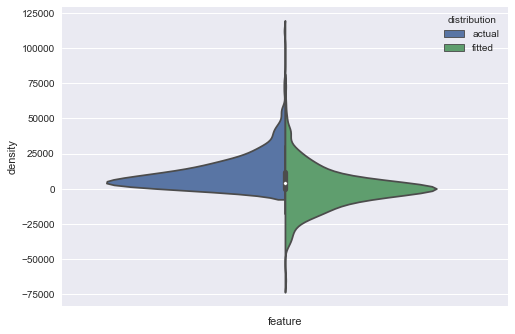

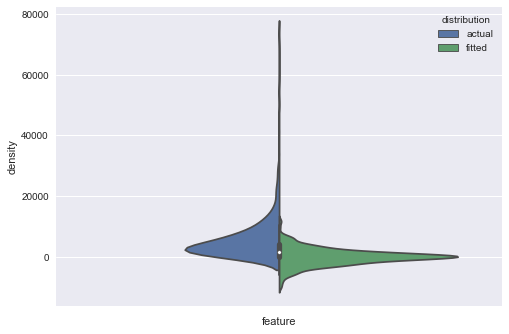

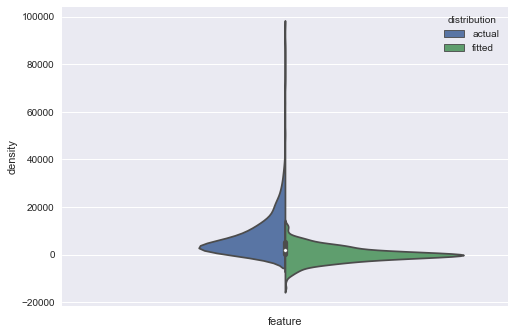

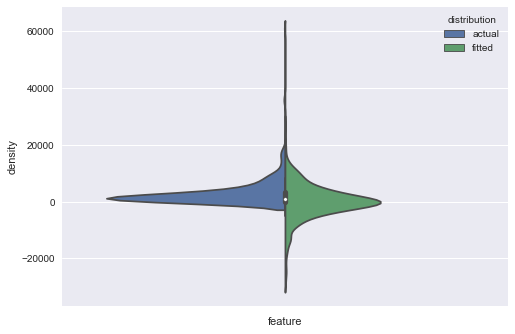

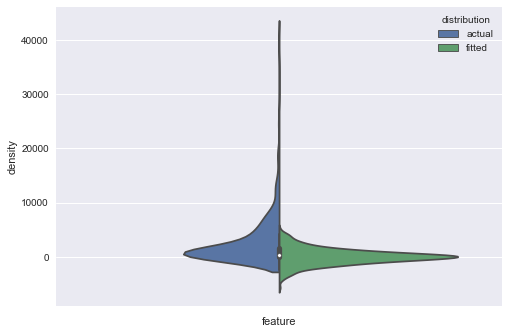

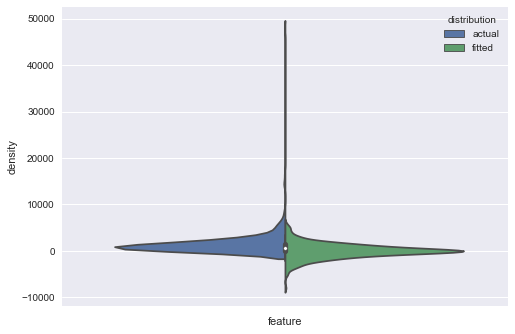

In [9]:
from visualisation.visualisation import Visualisation

gmm_viz = Visualisation(gmm, X, y)
for i in range(y.shape[1]):
    gmm_viz.plot_violin(y[:,i], y_hat[:,i])

In [10]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=20)
print("KL:", kl(p, q))
print("JS:", js(p, q))

KL: 0.4769256536873138
JS: 0.04245849433724949


In [12]:
from model.cgan import CGAN

cgan = CGAN(x_features=X.shape[1],
            y_features=y.shape[1],
            latent_dim=32,
            g_hidden=32,
            d_hidden=32,
            label_smooth=0.9,
            d_dropout=0.1,
            d_clip=0.01)

cgan.fit(dataset, epochs=1000, verbose=False, logdir="cgan_supermarket")

In [8]:
%load_ext tensorboard
%tensorboard --logdir C:/users/notes/grab/experiments/logs/cgan_supermarket

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 60612.

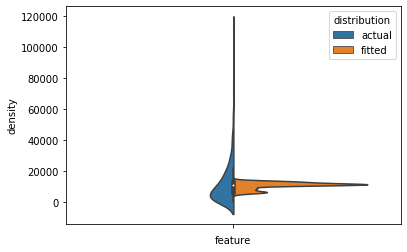

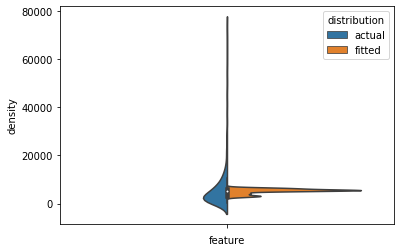

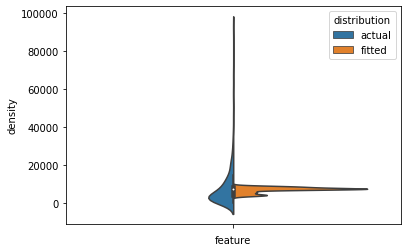

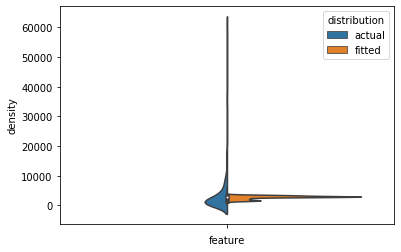

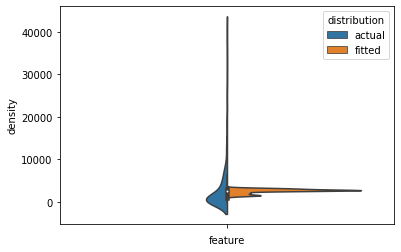

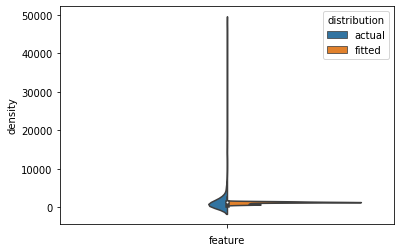

In [13]:
from visualisation.visualisation import Visualisation

y_hat = cgan.sample(X)
cgan_viz = Visualisation(cgan, X, y)
for i in range(y.shape[1]):
    cgan_viz.plot_violin(y[:,i], y_hat[:,i])

In [14]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=20)
print("fKL:", kl(p, q)) # TODO: q, p
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.199139025782249
rKL: 1.7869031078778672
JS: 0.17282325244283162
